# **0. Описание задачи словами**

**Задача:** Построить модель машинного обучения, которая будет предсказывать, согласится ли клиент банка на оформление срочного депозита (`deposit`) после маркетинговой телефонной кампании.

**Бизнес-контекст:** Банк хочет оптимизировать свои маркетинговые усилия. Модель, предсказывающая успешность звонка, позволит сконцентрировать ресурсы на наиболее перспективных клиентах, что повысит конверсию и снизит затраты.

**Тип задачи:** Бинарная классификация. Нам нужно предсказать один из двух классов:

*   `yes` - клиент оформит депозит.
*   `no` - клиент не оформит депозит.


In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

seed = 73

# **1. Считываем данные**

In [35]:
url = 'https://raw.githubusercontent.com/Lepsps/ML_homeworks/refs/heads/main/second_hm/dataset/bank.csv'

try:
    df = pd.read_csv(url)
    print("Датасет успешно загружен.")
    df.head()
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")

Датасет успешно загружен.


# **2. Разбиение данных на обучающую и тестовую выборки**

Крайне важно разделить данные до какой-либо обработки (EDA, масштабирование), чтобы избежать "утечки данных". Модель должна оцениваться на данных, которые она никогда не видела в процессе обучения. Мы используем стратифицированное разбиение (`stratify=y`), чтобы сохранить одинаковое соотношение классов (`yes`/`no`) в обеих выборках.

In [36]:
X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (8929, 16)
Размер тестовой выборки: (2233, 16)


# **3. Визуализация и вычисление основных характеристик**

Проведем исследовательский анализ данных на обучающей выборке.

Статистика по числовым признакам:


,age,balance,day,duration,campaign,pdays,previous
count,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000,8929.000000
mean,41.186023,1527.516295,15.686303,371.829656,2.518199,50.274387,0.813641
std,11.906220,3138.956630,8.388743,347.541205,2.736307,107.934880,2.246809
min,18.000000,-6847.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,123.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,549.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,1723.000000,21.000000,494.000000,3.000000,-1.000000,0.000000
max,93.000000,81204.000000,31.000000,3881.000000,63.000000,854.000000,55.000000



Соотношение классов в обучающей выборке:
deposit
no     0.526151
yes    0.473849
Name: proportion, dtype: float64


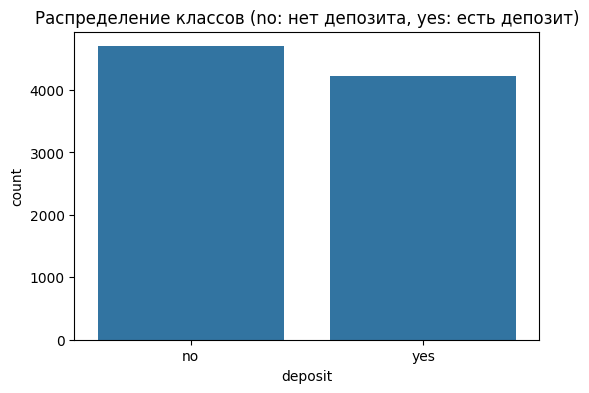

In [37]:
print("Статистика по числовым признакам:")
display(X_train.describe())

print("\nСоотношение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))

plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Распределение классов (no: нет депозита, yes: есть депозит)')
plt.show()

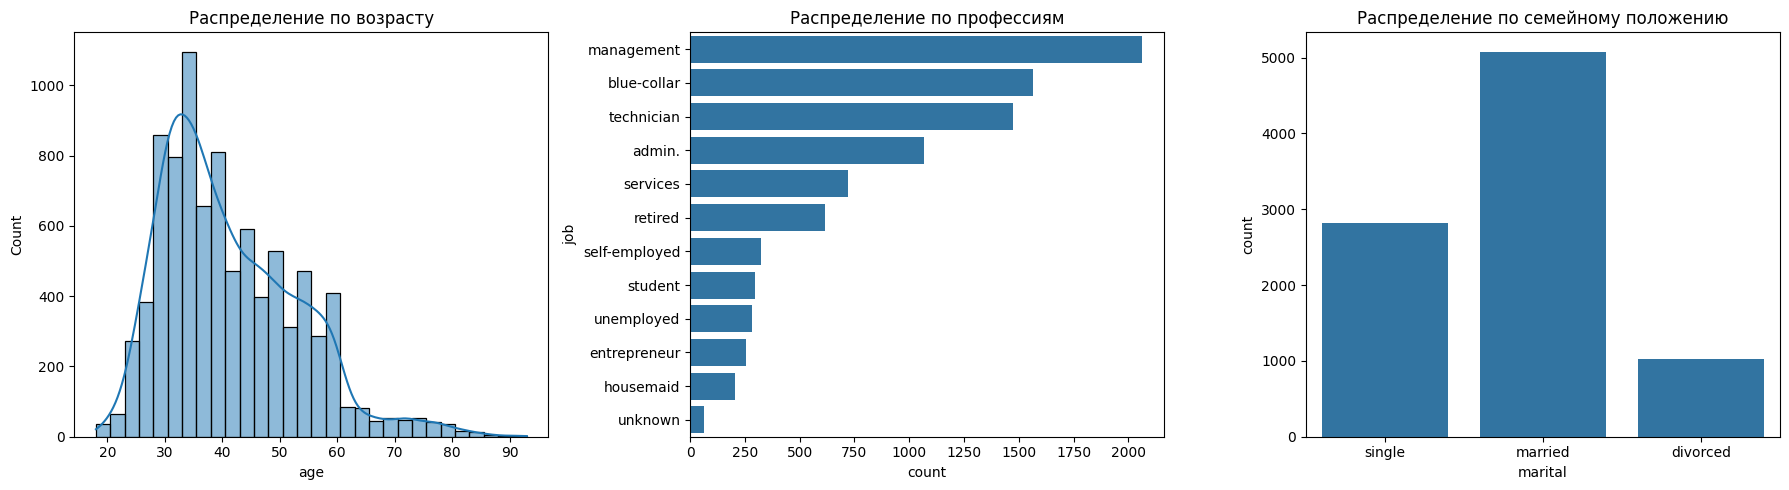

In [38]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(X_train['age'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Распределение по возрасту')

sns.countplot(y=X_train['job'], order = X_train['job'].value_counts().index, ax=axes[1])
axes[1].set_title('Распределение по профессиям')

sns.countplot(x=X_train['marital'], ax=axes[2])
axes[2].set_title('Распределение по семейному положению')

plt.tight_layout()
plt.show()

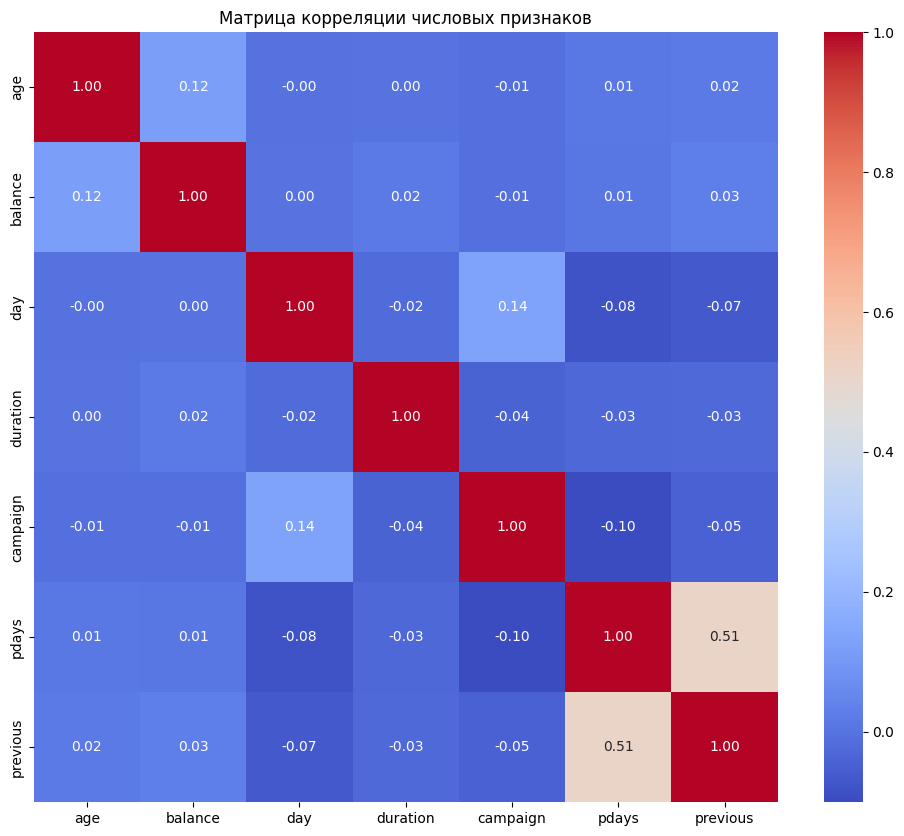

In [39]:
plt.figure(figsize=(12, 10))

numeric_cols = X_train.select_dtypes(include=np.number).columns
sns.heatmap(X_train[numeric_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Матрица корреляции числовых признаков')
plt.show()

# **4. Обработка пропущенных значений**

Проверим, есть ли в данных пропуски. В этом датасете они часто представлены не как `NaN`, а как строковое значение `unknown`.

In [40]:
print("Количество NaN значений:")
print(X_train.isnull().sum())

print("\nКоличество 'unknown' значений:")
for col in X_train.select_dtypes(include='object').columns:
    unknown_count = (X_train[col] == 'unknown').sum()
    if unknown_count > 0:
        print(f"{col}: {unknown_count}")

Количество NaN значений:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
dtype: int64

Количество 'unknown' значений:
job: 62
education: 396
contact: 1900
poutcome: 6707


In [48]:
X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)
X_train = X_train.drop('poutcome', axis=1)
X_test = X_test.drop('poutcome', axis=1)

print("\nРазмер обучающей выборки после удаления:", X_train.shape)


Размер обучающей выборки после удаления: (8929, 15)


**Остальные `unknown` значения будут обработаны `OneHotEncoder`**

# **5. и 6. Обработка признаков и нормализация**

Создадим единый конвейер (`pipeline`) для предобработки данных, чтобы избежать утечки данных.

*   **Категориальные признаки:** преобразуем с помощью `OneHotEncoder`.
*   **Числовые признаки:** масштабируем с помощью `StandardScaler`.


In [42]:
numeric_features = X_train.select_dtypes(include=np.number).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# **7. и 8. Запуск классификатора ближайших соседей и подбор гиперпараметра**


Лучшее значение k: 13

Отчет по классификации (k-NN (лучший k)): 
              precision    recall  f1-score   support

          no       0.80      0.84      0.82      1175
         yes       0.81      0.77      0.79      1058

    accuracy                           0.81      2233
   macro avg       0.81      0.80      0.81      2233
weighted avg       0.81      0.81      0.81      2233


Матрица рассогласования (k-NN (лучший k)):


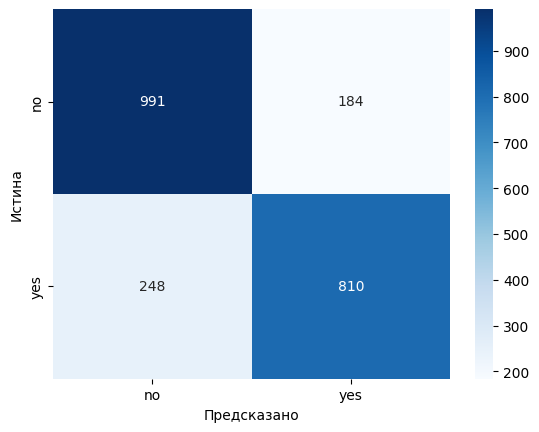

In [43]:
knn_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', KNeighborsClassifier())])
param_grid = {
    'classifier__n_neighbors': range(1, 31)
}

grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"\nЛучшее значение k: {grid_search.best_params_['classifier__n_neighbors']}")

best_knn = grid_search.best_estimator_
y_pred_knn = best_knn.predict(X_test)
y_proba_knn = best_knn.predict_proba(X_test)[:, 1]

def evaluate_model(model_name, y_true, y_pred):
    print(f"\nОтчет по классификации ({model_name}): ")
    print(classification_report(y_true, y_pred))
    print(f"\nМатрица рассогласования ({model_name}):")

    labels = best_knn.classes_
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
    plt.xlabel('Предсказано')
    plt.ylabel('Истина')
    plt.show()

evaluate_model("k-NN (лучший k)", y_test, y_pred_knn)

# **Комментарий**

Наилучшее качество было достигнуто при k=13.

Оценка итоговой модели на тестовой выборке показала высокий результат. Для целевого класса `yes` (клиент согласился на депозит) были достигнуты следующие метрики:

*   **Полнота (Recall):** `0.77` — модель успешно нашла 77% всех реальных клиентов,
согласившихся на вклад.
*   **Точность (Precision):** `0.81` — 81% клиентов, предсказанных моделью как "успешные", действительно оформили депозит.

Высокий F1-score (`0.79`) подтверждает хороший баланс между этими метриками. Матрица рассогласования показывает, что модель корректно определила `810` успешных клиентов, упустив при этом `248` потенциальных.

# **9. Запуск других классификаторов и сравнение**

**Модель 2: Логистическая регрессия**


Отчет по классификации (LogisticRegression): 
              precision    recall  f1-score   support

          no       0.82      0.81      0.81      1175
         yes       0.79      0.80      0.80      1058

    accuracy                           0.81      2233
   macro avg       0.81      0.81      0.81      2233
weighted avg       0.81      0.81      0.81      2233


Матрица рассогласования (LogisticRegression):


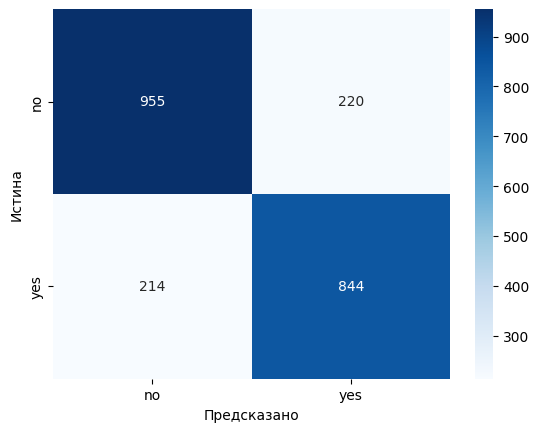

In [44]:
log_reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', LogisticRegression(random_state=seed, max_iter=1000, class_weight='balanced'))])

log_reg_pipeline.fit(X_train, y_train)
y_pred_log_reg = log_reg_pipeline.predict(X_test)

evaluate_model("LogisticRegression", y_test, y_pred_log_reg)

**Модель 3: Случайный лес (Random Forest)**


Отчет по классификации (RandomForest): 
              precision    recall  f1-score   support

          no       0.89      0.81      0.85      1175
         yes       0.81      0.89      0.85      1058

    accuracy                           0.85      2233
   macro avg       0.85      0.85      0.85      2233
weighted avg       0.85      0.85      0.85      2233


Матрица рассогласования (RandomForest):


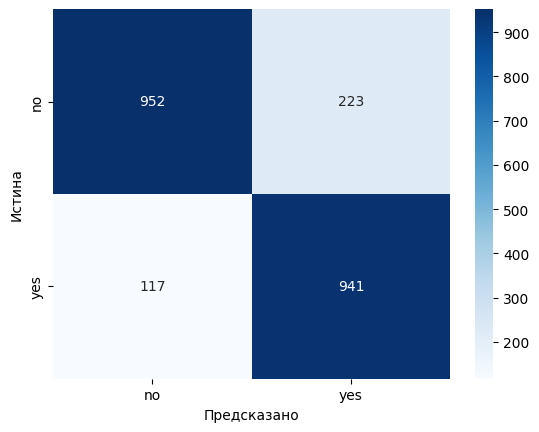

In [45]:
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=seed, n_estimators=150, class_weight='balanced', n_jobs=-1))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)

evaluate_model("RandomForest", y_test, y_pred_rf)

# **10. Борьба с несбалансированностью классов**

На этапе исследовательского анализа данных было выявлено незначительное преобладание класса `no` (52.6%) над классом `yes` (47.4%). Несмотря на то что такой дисбаланс не является критическим, для повышения качества модели и акцентирования внимания на поиске клиентов целевого класса (`yes`) был применен метод взвешивания классов.

В моделях **Логистической регрессии** и **Случайного леса** был использован встроенный гиперпараметр `class_weight='balanced'`. Этот подход автоматически вычисляет веса, обратно пропорциональные частоте классов, и применяет их в функции потерь. Таким образом, модель получает больший "штраф" за неверную классификацию объектов редкого класса, что приводит к улучшению метрики `recall` для класса `yes` и построению более полезной с практической точки зрения модели.

# **11. Исключение коррелированных переменных**

В рамках этапа №3 была построена и проанализирована матрица корреляции для всех числовых признаков. Анализ показал отсутствие сильной мультиколлинеарности между предикторами. Наибольший коэффициент корреляции Пирсона (`0.50`) наблюдался между переменными **pdays** (количество дней с последнего контакта) и **previous** (количество предыдущих контактов), что является логичной и ожидаемой связью.

Поскольку ни одна из пар признаков не продемонстрировала коэффициент корреляции, близкий к абсолютной единице (например, > 0.9), было принято решение не исключать какие-либо переменные из модели. Используемые ансамблевые методы (Случайный лес) устойчивы к умеренной корреляции, а удаление даже частично связанных признаков могло бы привести к потере ценной информации и снижению предсказательной способности итоговой модели.

# **12. Сделать общие выводы**

В ходе выполнения работы была успешно решена задача бинарной классификации для прогнозирования отклика клиентов на маркетинговое предложение банка.


*   **Предобработка данных:** Была выполнена полная предобработка данных, включающая кодирование категориальных признаков методом `One-Hot Encoding` и масштабирование числовых признаков с помощью `StandardScaler` для моделей, чувствительных к масштабу.
*    **Сравнение моделей:** Были обучены и оценены три алгоритма классификации: **k-ближайших соседей** (k-NN), **Логистическая регрессия** и **Случайный лес** (Random Forest). Для модели k-NN с помощью `GridSearchCV` был подобран оптимальный гиперпараметр `k=13`.
*   **Результаты:** Все три модели показали высокое качество. Наилучшие результаты по совокупности метрик продемонстрировал **Случайный лес**, достигнув на тестовой выборке `f1-score=0.85` для целевого класса `yes`. Эта модель также показала высокий баланс между точностью (`precision=0.81`) и полнотой `(recall=0.89`), что говорит о ее надежности и эффективности.

*   **Заключение:** Модель на основе алгоритма **Случайный лес** является наиболее подходящей для решения поставленной бизнес-задачи. Она способна с высокой точностью идентифицировать потенциальных клиентов, что позволяет рекомендовать ее для использования в реальных маркетинговых кампаниях с целью оптимизации ресурсов и повышения конверсии. Результаты также подтвердили важность этапов предобработки данных и подбора гиперпараметров для достижения максимального качества модели.  


    

    

    